# C matrices from MGC and DCORR

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
#from hyppo.independence import MGC
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap

import sys; sys.path.append('../')
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2

/home/rflperry/hyppo/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

In [3]:
## Define paths
#base_dir = Path('/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/')
base_dir = Path('/mnt/ssd3/ronan/data/gcca_old_min_rank-ZG3/')## Define paths

In [4]:
groups, labels = get_latents(base_dir, flag='_gcca-zg')

In [5]:
def doubly_center(D):
    n = D.shape[0]
    C = np.zeros(D.shape)
    diag_sum = np.sum(np.diag(D))
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            else:
                C[i,j] = D[i,j] - 1/(n-2)*np.sum(D[i,:]) - 1/(n-2)*np.sum(D[:,j]) + 1/((n-1)*(n-2))*diag_sum
    
    return C

In [88]:
def get_nn_graph(G, k=1):
    nn = np.zeros(G.shape)
    for i in range(nn.shape[0]):
        ## [k] to not include itself
        nn[i,:] = G[i,:] <= np.sort(G[i,:])[k-1]
    
    return nn

## Experts vs. Novices

In [111]:
ways = [[0],[0],[0],[1],[1],[1]]
X,Y = k_sample_transform(groups, ways=ways)
X = X[:,:,:3].reshape(X.shape[0],-1)

In [112]:
X_dists = pairwise_distances(X, metric='euclidean')
X_dists_c = doubly_center(X_dists)

Y_dists = pairwise_distances(Y, metric='sqeuclidean') / 2
Y_dists_c = doubly_center(Y_dists)

In [36]:
stat, pvalue, mgc_dict = multiscale_graphcorr(X_dists, Y_dists, workers=-1, reps=1000, compute_distance=None)
print(f'pvalue: {pvalue}')
print(f'opt_scale: {mgc_dict["opt_scale"]}')

pvalue: 0.001
opt_scale: [5, 2]


In [113]:
opt_xscale = 5
X_nn = get_nn_graph(X_dists_c, k = opt_xscale)

In [118]:
C_mgc = X_dists_c * X_nn * Y_dists_c
C_dcorr = X_dists_c * Y_dists_c

In [119]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
outer_labels = [i[0] for i in y]
inner_labels = [i[1] for i in y]
y_labels = [f'{a}' for a,b in y]

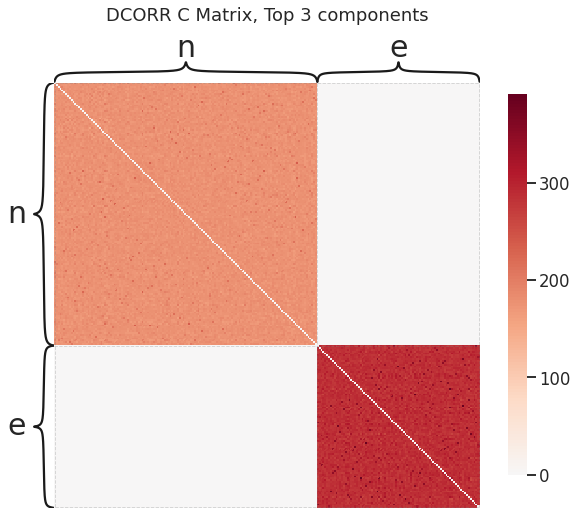

In [124]:
heatmap(C_dcorr, title=f'DCORR C Matrix, Top 3 components', transform=None, inner_hier_labels=y_labels)

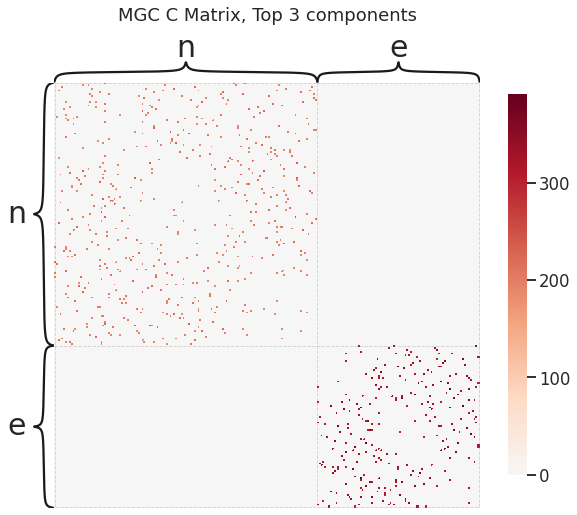

In [125]:
heatmap(C_mgc, title=f'MGC C Matrix, Top 3 components', transform=None, inner_hier_labels=y_labels)

## 2-way (states and traits)

In [126]:
ways = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
X,Y = k_sample_transform(groups, ways=ways)
X = X[:,:,:3].reshape(X.shape[0],-1)

In [127]:
X_dists = pairwise_distances(X, metric='euclidean')
X_dists_c = doubly_center(X_dists)

Y_dists = pairwise_distances(Y, metric='sqeuclidean') / 2
Y_dists_c = doubly_center(Y_dists)

In [48]:
stat, pvalue, mgc_dict = multiscale_graphcorr(X_dists, Y_dists, workers=-1, reps=1000, compute_distance=None)
print(f'pvalue: {pvalue}')
print(f'opt_scale: {mgc_dict["opt_scale"]}')

pvalue: 0.004
opt_scale: [207, 3]


In [128]:
opt_xscale = 207
X_nn = get_nn_graph(X_dists_c, k = opt_xscale)

In [129]:
C_mgc = X_dists_c * X_nn * Y_dists_c
C_dcorr = X_dists_c * Y_dists_c

In [130]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
outer_labels = [i[0] for i in y]
inner_labels = [i[1] for i in y]
y_labels = [f'{a} {b}' for a,b in y]

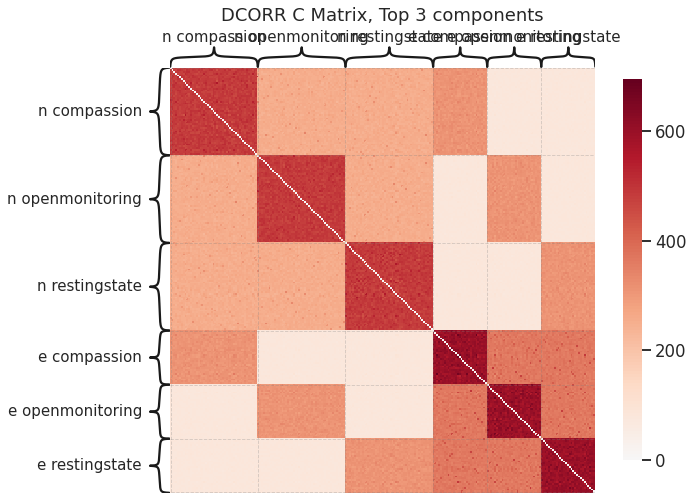

In [131]:
heatmap(C_dcorr,
        title=f'DCORR C Matrix, Top 3 components',
        transform=None,
        inner_hier_labels=y_labels,
        hier_label_fontsize=15,
        sort_nodes=False)

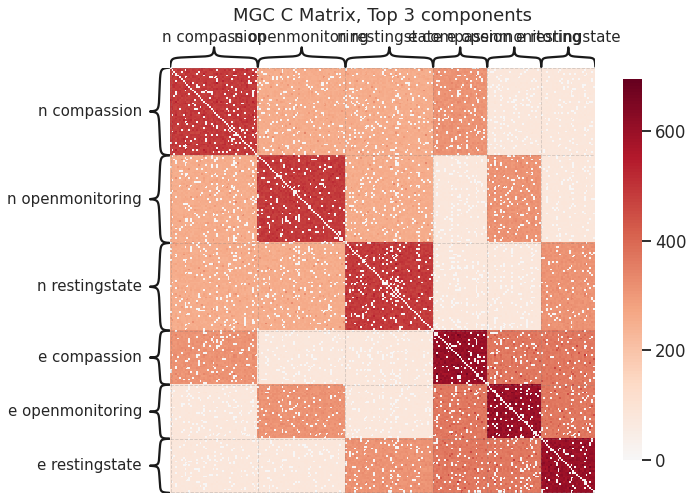

In [132]:
heatmap(C_mgc,
        title=f'MGC C Matrix, Top 3 components',
        transform=None,
        inner_hier_labels=y_labels,
        hier_label_fontsize=15,
        sort_nodes=False)